
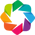

In [1]:
import holoviews as hv
hv.notebook_extension('bokeh')

In [2]:
import dask
import dask.dataframe as dd
import pandas as pd
from distributed import Client
client = Client(scheduler_file='/scratch/tmorton/dask/scheduler.json')

In [3]:
import sys
sys.path.append('..')

from explorer.catalog import ParquetCatalog, MatchedCatalog

def get_coadd(rerun, filt, tracts, unforced=False):
    table = 'unforced' if unforced else 'forced'
    files = ['{}/plots/{}/tract-{}/{}.parq'.format(rerun, filt, t, table) for t in tracts]
    return ParquetCatalog(files)
    
def get_visit(rerun, filt, tract, visit):
    file = '{}/plots/{}/tract-{}/visit-{}/catalog.parq'.format(rerun, filt, tract, visit)
    return ParquetCatalog([file])

In [4]:
rerun = '/scratch/tmorton/hscRerun/DM-12043/SSP_DEEP_XMM_LSS'
filt = 'HSC-Y'
tract = 8767
visit = 39308
coadd_cat = get_coadd(rerun, filt, [tract])
visit_cat = get_visit(rerun, filt, tract, visit)
matched = MatchedCatalog(coadd_cat, visit_cat)

In [5]:
matched.match()

INFO:root:74187 matched within 0.5 arcsec, 533824 did not.


In [8]:
matched.cat1.filenames

['/scratch/tmorton/hscRerun/DM-12043/SSP_DEEP_XMM_LSS/plots/HSC-Y/tract-8767/forced.parq']

In [9]:
matched.cat2.filenames

['/scratch/tmorton/hscRerun/DM-12043/SSP_DEEP_XMM_LSS/plots/HSC-Y/tract-8767/visit-39308/catalog.parq']

In [10]:
import hashlib

In [12]:
h = hashlib.md5(open('/scratch/tmorton/hscRerun/DM-12043/SSP_DEEP_XMM_LSS/plots/HSC-Y/tract-8767/visit-39308/catalog.parq','rb').read())

In [14]:
h.update(open('/scratch/tmorton/hscRerun/DM-12043/SSP_DEEP_XMM_LSS/plots/HSC-Y/tract-8767/forced.parq','rb').read())

In [22]:
from functools import reduce

def get_md5(file):
    return hashlib.md5(open(file, 'rb').read())

hs = [get_md5(f) for f in matched.cat1.filenames + matched.cat2.filenames]

In [34]:
files = matched.cat1.filenames + matched.cat2.filenames

h = get_md5(files[0])
for f in files[1:]:
    h.update(open(f, 'rb').read())

In [43]:
from operator import add
all_str = reduce(lambda s1, s2: s1 + s2, [open(f, 'rb').read() for f in files])
all_str = reduce(add, [open(f, 'rb').read() for f in files])
hashlib.md5(all_str).hexdigest()

'6890c36c42ac11d3fdf48038023a1136'

In [37]:
h = hashlib.md5(open(files[0], 'rb').read() + open(files[1], 'rb').read())

In [38]:
h.hexdigest()

'6890c36c42ac11d3fdf48038023a1136'

In [33]:
h.hexdigest()

'6890c36c42ac11d3fdf48038023a1136'

In [6]:
matched.match_inds

(Int64Index([38557811201802241, 38557811201802243, 38557811201802245,
             38557811201802246, 38557811201802253, 38557811201802254,
             38557811201802261, 38557811201802264, 38557811201802271,
             38557811201802275,
             ...
             38558653015403819, 38558653015403832, 38558653015403834,
             38558653015403846, 38558653015403850, 38558653015403856,
             38558653015403876, 38558653015403886, 38558653015403887,
             38558653015403935],
            dtype='int64', name='id', length=74187),
 Int64Index([33765478102991457, 33765478102991390, 33765478102991496,
             33765478102991406, 33765478102991554, 33765478102991537,
             33765478102991544, 33765478102991451, 33765478102991970,
             33765478102991946,
             ...
             33765740095996327, 33765740095996233, 33765740095996230,
             33765740095996206, 33765740095996295, 33765740095996252,
             33765740095996139, 33765740095996

In [7]:
matched.match_distance

id
38557811201802241    0.318744
38557811201802243    0.033105
38557811201802245    0.051222
38557811201802246    0.067007
38557811201802253    0.085067
38557811201802254    0.082547
38557811201802261    0.059324
38557811201802264    0.197573
38557811201802271    0.055050
38557811201802275    0.067426
38557811201802276    0.117568
38557811201802277    0.345547
38557811201802281    0.110582
38557811201802285    0.144625
38557811201802286    0.058335
38557811201802289    0.180912
38557811201802290    0.151955
38557811201802292    0.172866
38557811201802294    0.048732
38557811201802308    0.118854
38557811201802310    0.095068
38557811201802312    0.071344
38557811201802313    0.144514
38557811201802314    0.056725
38557811201802316    0.095568
38557811201802319    0.058367
38557811201802323    0.057085
38557811201802328    0.079084
38557811201802331    0.096711
38557811201802336    0.178358
                       ...   
38558653015403589    0.057609
38558653015403590    0.018612
3855865

In [6]:
from explorer.functors import (Mag, MagDiff, CustomFunctor, DeconvolvedMoments, Column,
                            SdssTraceSize, PsfSdssTraceSizeDiff, HsmTraceSize,
                            PsfHsmTraceSizeDiff, CompositeFunctor)

f = MagDiff('modelfit_CModel', 'base_PsfFlux')
mag = Mag('base_PsfFlux')

In [7]:
from explorer.plots import multi_scattersky, FlagSetter, FilterStream

In [8]:
from explorer.dataset import QADataset

data = QADataset(matched, mag, flags=['calib_psfUsed', 'qaBad_flag'])

In [9]:
data.ds

:Dataset   [ra,dec,x,label,calib_psfUsed,qaBad_flag]   (y0,match_distance)

In [10]:
filter_stream = FilterStream()
plot = multi_scattersky(data.ds.groupby('label'), filter_stream=filter_stream)

In [11]:
plot

:Layout
   .DynamicMap.I   :DynamicMap   [label]
   .DynamicMap.II  :DynamicMap   [label]
   .DynamicMap.III :DynamicMap   [label]
   .DynamicMap.IV  :DynamicMap   [label]
   .DynamicMap.V   :DynamicMap   [label]
   .DynamicMap.VI  :DynamicMap   [label]

In [12]:
import parambokeh

flag_setter = FlagSetter(filter_stream=filter_stream, flags=data.flags, bad_flags=data.flags)
parambokeh.Widgets(flag_setter, callback=flag_setter.event, push=False, on_init=True)

In [ ]:
matched